In [1]:
import numpy as np
import xarray as xr
import os
import cartopy.crs as ccrs
from cartopy.feature import OCEAN, LAND, BORDERS
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


Can't find requested entry point: GDALRegisterMe
Can't find requested entry point: GDALRegister_nitf
Can't find requested entry point: GDALRegisterMe
Can't find requested entry point: GDALRegister_nitf


In [2]:
# From: https://github.com/atmtools/typhon/blob/master/typhon/plots/colors/common.py
def cmap_from_act(file, name=None):
    """Import colormap from Adobe Color Table file.

    Parameters:
        file (str): Path to act file.
        name (str): Colormap name. Defaults to filename without extension.

    Returns:
        LinearSegmentedColormap.
    """
    # Extract colormap name from filename.
    if name is None:
        name = os.path.splitext(os.path.basename(file))[0]

    # Read binary file and determine number of colors
    rgb = np.fromfile(file, dtype=np.uint8)
    if rgb.shape[0] >= 770:
        ncolors = rgb[768] * 2**8 + rgb[769]
    else:
        ncolors = 256

    colors = rgb[:ncolors*3].reshape(ncolors, 3) / 255
    # FIX the last value of the modis colorbar...
    colors[-1] = colors[-2]
    # Create and register colormap...
    cmap = LinearSegmentedColormap.from_list(name, colors, N=ncolors)
    plt.register_cmap(cmap=cmap)  # Register colormap.

    # ... and the reversed colormap.
    cmap_r = LinearSegmentedColormap.from_list(
            name + '_r', np.flipud(colors), N=ncolors)
    plt.register_cmap(cmap=cmap_r)

    return cmap

In [3]:
temp_ds = xr.open_rasterio(r'..\Data\MOD_LSTD_M_2021-10-01_rgb_360x180.FLOAT.TIFF')

In [4]:
# Mask 99999 values
ds_masked = temp_ds.where(temp_ds != 99999.) 

In [5]:
# Load the colormap - https://neo.gsfc.nasa.gov/palettes/modis_lst.act
modis_cmap = cmap_from_act("modis_lst.act", name=None)

In [6]:
# Europe extent
extent = (-15.5, 35, 32, 72)

In [7]:
# Get raster points
temp_pts = ds_masked.to_dataframe(name="t").reset_index()

In [8]:
# Get points within the extent

pts_within = np.array([(pt["x"], pt["y"], pt["t"]) for i, pt in temp_pts.iterrows() 
          if (extent[0] < pt["x"] < extent[1]) and (extent[2] < pt["y"] < extent[3])])
temps_within = [round(pt[2]) for pt in pts_within if not np.isnan(pt[2])]
min_t = min(temps_within)
max_t = max(temps_within)

In [9]:
# Font size
font_min = 8
font_max = 14

t_range = (max_t - min_t)  
font_range = (font_max - font_min)  

In [10]:
cbar_kwargs = {'orientation':'horizontal', 
               'shrink':0.6, 
               'aspect':20, 
               "pad": 0.05,
               'label':'Temperature (°C)'}

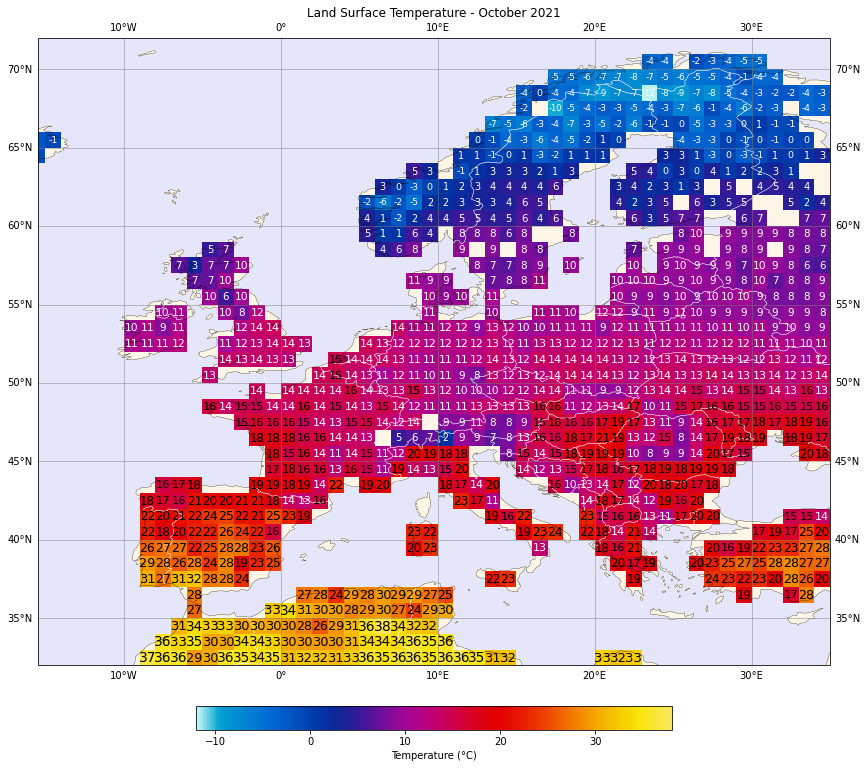

In [11]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines(lw=0.3)
ax.add_feature(OCEAN, color="lavender")
ax.add_feature(LAND, color="oldlace")
ax.add_feature(BORDERS, 
            linestyle='-',
            lw=0.6,
            edgecolor='white')
ax.gridlines(color='grey',
            alpha=0.6,
            draw_labels=True)

# Plot the raster
temp_plt = ds_masked.plot(cmap=modis_cmap, 
                        ax=ax,
                        cbar_kwargs=cbar_kwargs,
                        transform=ccrs.PlateCarree())

# Add Labels to plot
for i, pt in enumerate(pts_within):
    if np.isnan(pt[2]):
        continue
    # Scale the font size with temperature
    font_value = (((round(pt[2]) - min_t) * font_range) / t_range) + font_min
    label_color = "white" if round(pt[2]) < 15 else "black"
    ax.annotate(round(pt[2]), 
                (pt[0], pt[1]), 
                ha="center", 
                va="center", 
                weight="ultralight",
                color=label_color,
                fontsize=font_value)

ax.set_extent (extent, ccrs.PlateCarree())
ax.set_title("Land Surface Temperature - October 2021")
temp_plt.set_clim(min_t, max_t)
plt.tight_layout()
plt.savefig(r"10_Raster.png",
            bbox_inches='tight',
            dpi=300,
            pad_inches=0.15)

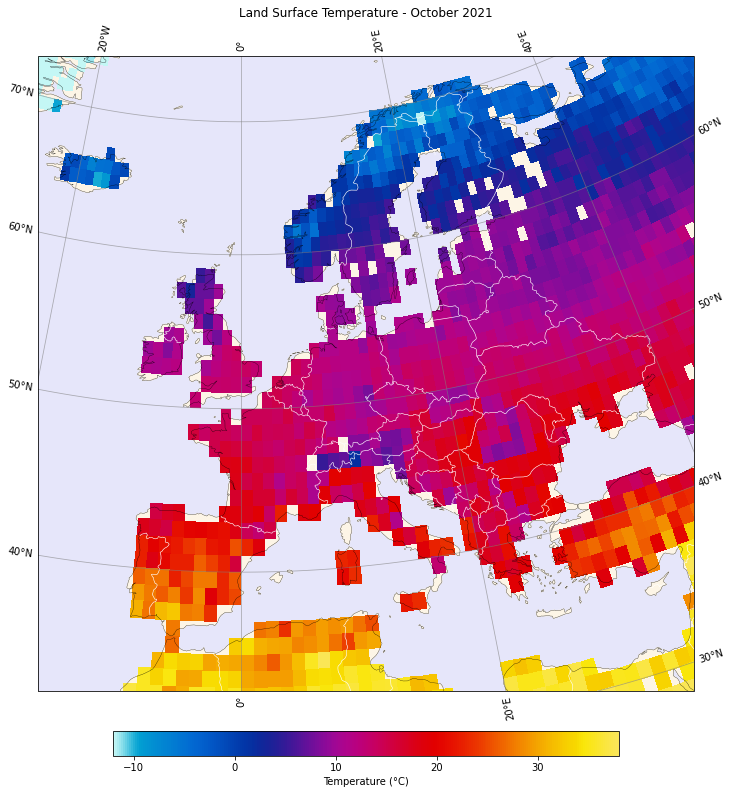

In [12]:
# Plot the raster in AlbersEqualArea projection
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(projection=ccrs.AlbersEqualArea())
ax.coastlines(lw=0.3)
ax.add_feature(OCEAN, color="lavender")
ax.add_feature(LAND, color="oldlace")
ax.add_feature(BORDERS, 
            linestyle='-',
            lw=0.6,
            edgecolor='white')
ax.gridlines(color='grey',
            alpha=0.6,
            draw_labels=True)

# Plot the raster
temp_plt = ds_masked.plot(cmap=modis_cmap, 
                        ax=ax,
                        cbar_kwargs=cbar_kwargs,
                        transform=ccrs.PlateCarree())

ax.set_extent (extent, ccrs.PlateCarree())
ax.set_title("Land Surface Temperature - October 2021")
temp_plt.set_clim(min_t, max_t)
plt.tight_layout()
plt.savefig(r"10_Raster_Albers.png",
            bbox_inches='tight',
            dpi=300,
            pad_inches=0.15)